Processing files: 100%|██████████| 50/50 [08:38<00:00, 10.38s/it]


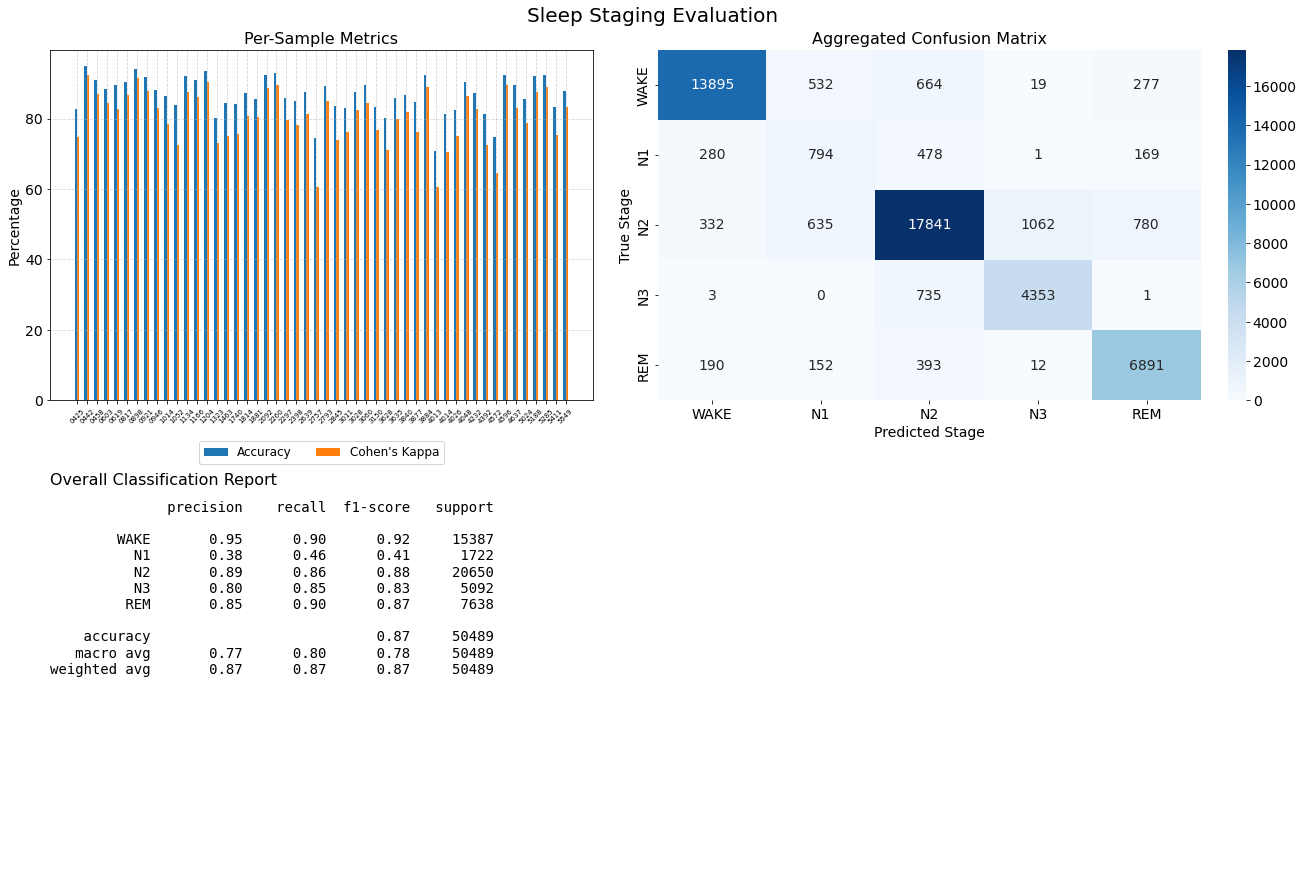

Displaying hypnogram comparison for sample: shhs1-200425


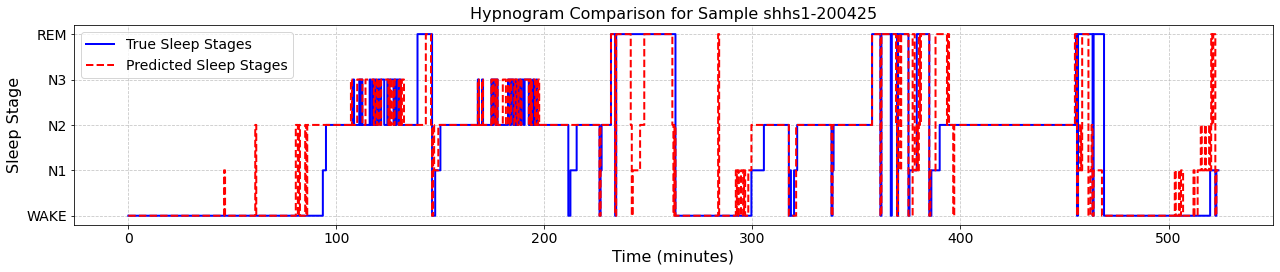

In [2]:
import os
import glob
import numpy as np
import mne
import xml.etree.ElementTree as ET
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, cohen_kappa_score
import yasa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Import tqdm for progress bar
import warnings  # Import warnings module

# Suppress all warnings
warnings.filterwarnings("ignore")

# Define stage names for labeling
STAGE_NAMES = ["WAKE", "N1", "N2", "N3", "REM"]

def parse_nsrr_xml(xml_file):
    """
    Parses an NSRR XML file (expected to end with "-nsrr.xml") to extract sleep stage annotations.
    Assumes each "ScoredEvent" with EventType "Stages|Stages" contains:
      - EventConcept: where the last element after splitting by "|" is the stage (numeric)
      - Duration: duration in seconds (must be a multiple of 30)
    Returns:
      A numpy array of sleep stage values repeated for each 30-second epoch.
    """
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()
    except Exception as e:
        raise ValueError(f"Error parsing XML file {xml_file}: {e}")

    hypnogram = []
    for event in root.findall(".//ScoredEvent"):
        event_type = event.find("EventType")
        if event_type is None or event_type.text != "Stages|Stages":
            continue
        duration_elem = event.find("Duration")
        concept_elem = event.find("EventConcept")
        if duration_elem is None or concept_elem is None:
            continue
        # Extract the stage (assumed numeric) from EventConcept
        stage_str = concept_elem.text.split("|")[-1]
        hypnogram.append((stage_str, duration_elem.text))
    
    stages = []
    for stage_str, duration_str in hypnogram:
        try:
            stage = int(stage_str)
        except ValueError:
            continue  # Skip non-numeric annotations
        duration = float(duration_str)
        if duration % 30 != 0:
            raise ValueError("Annotation duration is not a multiple of 30 seconds.")
        epochs_duration = int(duration) // 30
        stages.extend([stage] * epochs_duration)
    
    if not stages:
        raise ValueError("No valid sleep stage annotations were found in the XML file.")
    
    return np.array(stages)

def map_stage(stage):
    """
    Maps the raw stage integer from the XML to a sleep stage label for five classes.
    Mapping:
      - 0 -> WAKE
      - 1 -> N1
      - 2 -> N2
      - 3 or 4 -> N3   (N3 and N4 merged)
      - 5 -> REM
    Any other stage is mapped to "UNS".
    """
    if stage == 0:
        return "WAKE"
    elif stage == 1:
        return "N1"
    elif stage == 2:
        return "N2"
    elif stage in (3, 4):
        return "N3"
    elif stage == 5:
        return "REM"
    else:
        return "UNS"

def evaluate_sleep_staging(edf_file, xml_file):
    """
    Evaluates sleep staging on one EDF file paired with its NSRR XML annotation.
    Performs:
      1. Reading and preprocessing the EDF file.
      2. Parsing XML to extract true sleep stage annotations.
      3. Mapping annotations to stage labels.
      4. Automatic sleep staging using yasa.
      5. Computation of evaluation metrics and returning true and predicted integer labels.
      
    Returns a dictionary with:
      - accuracy: in percentage
      - confusion_matrix: for the 5 classes with fixed label order [0,1,2,3,4]
      - classification_report: full report as a string
      - cohen_kappa: the kappa statistic
      - true_int: array of true integer labels
      - pred_int: array of predicted integer labels
    """
    try:
        raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)
    except Exception as e:
        raise ValueError(f"Failed to read EDF file {edf_file}: {e}")
    
    # Resample and filter the data for analysis
    raw.resample(100, npad="auto")
    raw.filter(0.3, 45, fir_design="firwin", verbose=False)

    # Parse XML annotations and map to stage labels
    hypnogram = parse_nsrr_xml(xml_file)
    hypno_labels = [map_stage(stage) for stage in hypnogram]
    true_hyp = yasa.Hypnogram(hypno_labels, freq="30s")
    true_int = true_hyp.as_int()

    # Perform automatic sleep staging using yasa
    try:
        sls = yasa.SleepStaging(raw, eeg_name="EEG", eog_name="EOG(L)", emg_name="EMG")
    except Exception as e:
        raise ValueError(f"Error initializing SleepStaging: {e}")
    
    try:
        hypno_pred = sls.predict()
    except Exception as e:
        raise ValueError(f"Error obtaining sleep staging predictions: {e}")
    
    pred_int = yasa.hypno_str_to_int(hypno_pred)

    if len(true_int) != len(pred_int):
        raise ValueError("Mismatch in the number of epochs between true annotations and predictions.")
    
    accuracy = 100 * accuracy_score(true_int, pred_int)
    cm = confusion_matrix(true_int, pred_int, labels=[0, 1, 2, 3, 4])
    class_report = classification_report(true_int, pred_int, target_names=STAGE_NAMES)
    kappa = cohen_kappa_score(true_int, pred_int)

    metrics = {
        "accuracy": accuracy,
        "confusion_matrix": cm,
        "classification_report": class_report,
        "cohen_kappa": kappa,
        "true_int": true_int,
        "pred_int": pred_int
    }
    return metrics

def process_all_files(dataset_dir):
    """
    Processes all EDF/NSRR XML pairs in the dataset directory.
    Assumes each EDF file has a matching XML file with the same base name plus "-nsrr.xml".
    Aggregates per-sample metrics and accumulates overall true and predicted labels.
    
    Returns:
      - all_metrics: dictionary mapping sample names to their metrics
      - overall_true: concatenated true labels for all samples
      - overall_pred: concatenated predicted labels for all samples
    """
    all_metrics = {}
    overall_true = []
    overall_pred = []
    edf_files = glob.glob(os.path.join(dataset_dir, "**", "*.edf"), recursive=True)
    if not edf_files:
        raise ValueError("No EDF files found in the dataset directory.")

    # Wrap the loop with tqdm for a progress bar
    for edf_file in tqdm(edf_files, desc="Processing files"):
        # Use the EDF file's base name and add "-nsrr.xml" at the end.
        base = os.path.splitext(edf_file)[0]
        xml_file = base + "-nsrr.xml"
        sample_name = os.path.basename(base)
        if not os.path.exists(xml_file):
            continue  # Skip silently if XML file is missing
        try:
            metrics = evaluate_sleep_staging(edf_file, xml_file)
            all_metrics[sample_name] = metrics
            overall_true.extend(metrics["true_int"])
            overall_pred.extend(metrics["pred_int"])
        except Exception as e:
            # Skip files with errors silently
            continue
    return all_metrics, np.array(overall_true), np.array(overall_pred)

def plot_hypnogram_comparison(true_int, pred_int, epoch_duration=30, title="Hypnogram Comparison"):
    """
    Creates a step plot comparing the true and predicted sleep stage annotations.
    The x-axis represents time in minutes while the y-axis shows sleep stages, mapped to the defined stage names.
    """
    # Create time axis in minutes
    time_axis = np.arange(len(true_int)) * (epoch_duration / 60)
    plt.figure(figsize=(18, 4))
    # Draw the true hypnogram with a solid line
    plt.step(time_axis, true_int, where="post", label="True Sleep Stages", linewidth=2, color="blue")
    # Draw the predicted hypnogram with a dashed line
    plt.step(time_axis, pred_int, where="post", label="Predicted Sleep Stages", linewidth=2, linestyle="--", color="red")
    plt.xlabel("Time (minutes)")
    plt.ylabel("Sleep Stage")
    plt.title(title)
    # Set y-axis tick labels corresponding to stage names
    plt.yticks(ticks=[0, 1, 2, 3, 4], labels=STAGE_NAMES)
    plt.legend()
    plt.grid(True, which="both", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Set publication-ready matplotlib settings
    plt.rcParams.update({
        "font.size": 14,
        "figure.figsize": (18, 10),
        "axes.titlesize": 16,
        "axes.labelsize": 16,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 14,
        "figure.titlesize": 18,
        "lines.linewidth": 2
    })
    
    # Define dataset directory
    dataset_dir = "dataset/"
    try:
        metrics_dict, overall_true, overall_pred = process_all_files(dataset_dir)
    except Exception as e:
        # Suppress error message
        metrics_dict, overall_true, overall_pred = {}, np.array([]), np.array([])

    if metrics_dict:
        sample_names = list(metrics_dict.keys())
        
        # Extract sample numbers from sample names, e.g., for display on the x-axis of a bar chart.
        sample_numbers = [s[-4:] for s in sample_names]
        
        # Use sample numbers (1, 2, ...) along x-axis for bar chart
        x_values = np.arange(1, len(sample_names) + 1)
        accuracies = [metrics_dict[s]["accuracy"] for s in sample_names]
        kappas = [metrics_dict[s]["cohen_kappa"] * 100 for s in sample_names]
        
        # Aggregate confusion matrix across samples
        agg_cm = None
        for s in sample_names:
            if agg_cm is None:
                agg_cm = metrics_dict[s]["confusion_matrix"]
            else:
                agg_cm += metrics_dict[s]["confusion_matrix"]
        
        # Compute overall classification report from overall labels
        overall_class_report = classification_report(overall_true, overall_pred, target_names=STAGE_NAMES)
        
        # Create a combined figure with three subplots: bar chart, confusion matrix, and classification report text
        fig = plt.figure(constrained_layout=True, figsize=(18, 12))
        gs = fig.add_gridspec(2, 2)
        
        # Subplot 1: Grouped Bar Chart (per-sample metrics)
        ax1 = fig.add_subplot(gs[0, 0])
        width = 0.25  # width for each bar
        ax1.bar(x_values - width/2, accuracies, width, label='Accuracy')
        ax1.bar(x_values + width/2, kappas, width, label="Cohen's Kappa")
        ax1.set_ylabel("Percentage", fontsize=14)
        ax1.set_title("Per-Sample Metrics", fontsize=16)
        ax1.set_xticks(x_values)
        ax1.set_xticklabels(sample_numbers, rotation=45, ha='center', fontsize=7)
        ax1.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=2)
        ax1.grid(True, linestyle="--", alpha=0.5)
        
        # Subplot 2: Aggregated Confusion Matrix Heatmap
        ax2 = fig.add_subplot(gs[0, 1])
        sns.heatmap(agg_cm, annot=True, fmt="d", cmap="Blues", 
                    xticklabels=STAGE_NAMES, yticklabels=STAGE_NAMES, ax=ax2)
        ax2.set_title("Aggregated Confusion Matrix", fontsize=16)
        ax2.set_xlabel("Predicted Stage", fontsize=14)
        ax2.set_ylabel("True Stage", fontsize=14)
        
        # Subplot 3: Overall Classification Report as Text
        ax3 = fig.add_subplot(gs[1, :])
        ax3.axis("off")
        ax3.set_title("Overall Classification Report", fontsize=16, pad=30, loc='left')
        report_text = overall_class_report.replace("\n", "\n")
        ax3.text(0, 0.5, report_text, fontsize=14, family="monospace")
        plt.suptitle("Sleep Staging Evaluation", fontsize=20)
        plt.show()
        
        # Additionally, to further elevate the analysis using YASA functionality,
        # select a sample and visualize a hypnogram comparison between true and predicted sleep stages.
        example_sample = sample_names[0]
        sample_metrics = metrics_dict[example_sample]
        print(f"Displaying hypnogram comparison for sample: {example_sample}")
        plot_hypnogram_comparison(sample_metrics["true_int"], sample_metrics["pred_int"],
                                  title=f"Hypnogram Comparison for Sample {example_sample}")

In [7]:
import os
import glob
import numpy as np
import mne
import xml.etree.ElementTree as ET
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, cohen_kappa_score
import yasa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
from datetime import datetime
import logging
import sys
from contextlib import redirect_stdout, redirect_stderr
import io

# Configuration and Setup
CURRENT_DATE = "2025-02-03 12:01:57"
CURRENT_USER = "ZiadATAhmed"

# Create logs directory if it doesn't exist
os.makedirs('logs', exist_ok=True)

# Set up logging
log_filename = os.path.join('logs', f'sleep_analysis_{datetime.now().strftime("%Y%m%d_%H%M%S")}.log')
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s | %(levelname)s | %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    handlers=[
        logging.FileHandler(log_filename),
        logging.StreamHandler(open(os.devnull, 'w'))  # Redirect stdout to null
    ]
)
logger = logging.getLogger(__name__)

# Suppress warnings
warnings.filterwarnings("ignore")

# Define stage names and labels for all possible stages
STAGE_NAMES = ["WAKE", "N1", "N2", "N3", "REM", "UNKNOWN"]
STAGE_LABELS = [0, 1, 2, 3, 5, 6]  # Include all possible stage values

def suppress_output(func):
    """Decorator to suppress stdout and stderr output"""
    def wrapper(*args, **kwargs):
        with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
            result = func(*args, **kwargs)
        return result
    return wrapper

class SleepAnalysis:
    def __init__(self, dataset_dir):
        self.dataset_dir = dataset_dir
        self.metrics_dict = {}
        self.overall_true = []
        self.overall_pred = []
        logger.info(f"Analysis initialized by {CURRENT_USER} at {CURRENT_DATE}")

    def parse_nsrr_xml(self, xml_file):
        """Parse NSRR XML file for sleep stage annotations."""
        try:
            tree = ET.parse(xml_file)
            root = tree.getroot()
            
            stages = []
            for event in root.findall(".//ScoredEvent"):
                if event.find("EventType").text == "Stages|Stages":
                    stage = int(event.find("EventConcept").text.split("|")[-1])
                    duration = float(event.find("Duration").text)
                    epochs = int(duration // 30)
                    stages.extend([stage] * epochs)
                    
            return np.array(stages)
        except Exception as e:
            logger.error(f"Error parsing XML file {xml_file}: {str(e)}")
            raise

    @suppress_output
    def preprocess_eeg(self, raw):
        """Preprocess EEG data."""
        raw.resample(100, verbose=False)
        raw.filter(0.3, 45, verbose=False)
        return raw

    def detect_artifacts(self, raw, threshold=100e-6):
        """Detect artifacts in EEG data."""
        data = raw.get_data()
        artifacts = np.abs(data) > threshold
        artifact_percentage = np.mean(artifacts) * 100
        logger.info(f"Artifact percentage: {artifact_percentage:.2f}%")
        return artifacts

    @suppress_output
    def evaluate_sleep_staging(self, edf_file, xml_file):
        """Evaluate sleep staging for a single recording."""
        try:
            # Load and preprocess EEG
            raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)
            raw = self.preprocess_eeg(raw)

            # Get true stages
            true_stages = self.parse_nsrr_xml(xml_file)
            
            # Perform automatic sleep staging
            sls = yasa.SleepStaging(raw, eeg_name="EEG", eog_name="EOG(L)", emg_name="EMG")
            pred_stages = sls.predict()
            pred_int = yasa.hypno_str_to_int(pred_stages)

            # Calculate metrics using all possible labels
            metrics = {
                "accuracy": accuracy_score(true_stages, pred_int) * 100,
                "confusion_matrix": confusion_matrix(true_stages, pred_int, 
                                                  labels=STAGE_LABELS),
                "classification_report": classification_report(true_stages, pred_int, 
                                                          labels=STAGE_LABELS,
                                                          target_names=STAGE_NAMES,
                                                          zero_division=0),
                "cohen_kappa": cohen_kappa_score(true_stages, pred_int),
                "true_stages": true_stages,
                "pred_stages": pred_int,
                "raw": raw
            }
            
            return metrics
        
        except Exception as e:
            logger.error(f"Error processing {edf_file}: {str(e)}")
            raise

    def process_dataset(self):
        """Process all files in the dataset."""
        edf_files = glob.glob(os.path.join(self.dataset_dir, "*.edf"))
        
        for edf_file in tqdm(edf_files, desc="Processing files", file=sys.stdout):
            try:
                xml_file = edf_file.replace(".edf", "-nsrr.xml")
                if not os.path.exists(xml_file):
                    logger.warning(f"No XML file found for {edf_file}")
                    continue
                    
                metrics = self.evaluate_sleep_staging(edf_file, xml_file)
                sample_name = os.path.basename(edf_file).replace(".edf", "")
                self.metrics_dict[sample_name] = metrics
                
                self.overall_true.extend(metrics["true_stages"])
                self.overall_pred.extend(metrics["pred_stages"])
                
                logger.info(f"Successfully processed {sample_name}")
                
            except Exception as e:
                logger.error(f"Error processing {edf_file}: {str(e)}")
                continue

    def plot_results(self):
        """Generate and save all plots."""
        if not self.metrics_dict:
            logger.error("No data available for plotting")
            return

        # Create output directory for plots
        output_dir = f"results_{CURRENT_DATE.split()[0]}"
        os.makedirs(output_dir, exist_ok=True)

        # Create a single figure with three panels
        fig = plt.figure(figsize=(20, 15))
        gs = fig.add_gridspec(2, 2)

        # Panel 1: Performance Metrics Bar Chart
        ax1 = fig.add_subplot(gs[0, 0])
        sample_names = list(self.metrics_dict.keys())
        x_values = np.arange(len(sample_names))
        accuracies = [m["accuracy"] for m in self.metrics_dict.values()]
        kappas = [m["cohen_kappa"] * 100 for m in self.metrics_dict.values()]
        
        width = 0.35
        ax1.bar(x_values - width/2, accuracies, width, label='Accuracy')
        ax1.bar(x_values + width/2, kappas, width, label="Cohen's Kappa")
        ax1.set_ylabel("Percentage", fontsize=12)
        ax1.set_title("Per-Sample Performance Metrics", fontsize=14)
        ax1.set_xticks(x_values)
        ax1.set_xticklabels([s[-4:] for s in sample_names], rotation=45)
        ax1.legend()
        ax1.grid(True, linestyle='--', alpha=0.7)

        # Panel 2: Aggregated Confusion Matrix
        ax2 = fig.add_subplot(gs[0, 1])
        agg_cm = sum([m["confusion_matrix"] for m in self.metrics_dict.values()])
        sns.heatmap(agg_cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=STAGE_NAMES, yticklabels=STAGE_NAMES, ax=ax2)
        ax2.set_title("Aggregated Confusion Matrix", fontsize=14)
        ax2.set_xlabel("Predicted Stage", fontsize=12)
        ax2.set_ylabel("True Stage", fontsize=12)

        # Panel 3: Classification Report (as text)
        ax3 = fig.add_subplot(gs[1, :])
        ax3.axis('off')
        overall_report = classification_report(self.overall_true, self.overall_pred,
                                            labels=STAGE_LABELS,
                                            target_names=STAGE_NAMES,
                                            zero_division=0)
        ax3.text(0.1, 0.1, f"Overall Classification Report:\n\n{overall_report}",
                 fontfamily='monospace', fontsize=10)

        # Adjust layout and save
        plt.suptitle(f"Sleep Staging Analysis Summary - {CURRENT_DATE}", fontsize=16)
        plt.tight_layout()
        
        # Save the combined figure
        plt.savefig(os.path.join(output_dir, "combined_analysis.png"), 
                    bbox_inches='tight', dpi=300)
        plt.close()

        # Also save individual hypnograms
        for sample_name, metrics in self.metrics_dict.items():
            plt.figure(figsize=(15, 5))
            time_axis = np.arange(len(metrics["true_stages"])) * 30 / 3600  # Convert to hours
            
            plt.plot(time_axis, metrics["true_stages"], label="True", alpha=0.7)
            plt.plot(time_axis, metrics["pred_stages"], label="Predicted", alpha=0.7)
            
            plt.title(f"Hypnogram Comparison - {sample_name}")
            plt.xlabel("Time (hours)")
            plt.ylabel("Sleep Stage")
            plt.yticks(range(len(STAGE_NAMES)), STAGE_NAMES)
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            
            plt.savefig(os.path.join(output_dir, f"hypnogram_{sample_name}.png"))
            plt.close()

        logger.info(f"Plots saved to {output_dir}")

    def generate_report(self):
        """Generate a comprehensive report."""
        report_path = f"sleep_analysis_report_{CURRENT_DATE.split()[0]}.txt"
        
        with open(report_path, 'w') as f:
            f.write(f"Sleep Analysis Report\n")
            f.write(f"Generated by: {CURRENT_USER}\n")
            f.write(f"Date: {CURRENT_DATE}\n")
            f.write("="*50 + "\n\n")
            
            # Overall metrics
            overall_acc = accuracy_score(self.overall_true, self.overall_pred) * 100
            overall_kappa = cohen_kappa_score(self.overall_true, self.overall_pred)
            
            f.write(f"Overall Metrics:\n")
            f.write(f"Accuracy: {overall_acc:.2f}%\n")
            f.write(f"Cohen's Kappa: {overall_kappa:.2f}\n\n")
            
            # Per-sample metrics
            f.write("Per-sample Metrics:\n")
            for sample_name, metrics in self.metrics_dict.items():
                f.write(f"\n{sample_name}:\n")
                f.write(f"Accuracy: {metrics['accuracy']:.2f}%\n")
                f.write(f"Cohen's Kappa: {metrics['cohen_kappa']:.2f}\n")
                f.write("\nClassification Report:\n")
                f.write(metrics['classification_report'])
                f.write("\n" + "-"*50 + "\n")

        logger.info(f"Report generated: {report_path}")

def main():
    try:
        # Initialize analysis
        dataset_dir = "dataset/"
        analysis = SleepAnalysis(dataset_dir)
        
        # Process dataset
        logger.info("Starting dataset processing")
        analysis.process_dataset()
        
        # Generate results
        logger.info("Generating plots and reports")
        analysis.plot_results()
        analysis.generate_report()
        
        logger.info("Analysis completed successfully")
        
    except Exception as e:
        logger.error(f"Analysis failed: {str(e)}")
        raise

if __name__ == "__main__":
    main()

Processing files: 100%|██████████| 50/50 [09:03<00:00, 10.86s/it]
